In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import os
from random import randint

In [2]:
def get_fold_results(fold):
    f = open(f"../competitive_data/results/final_results_{fold}.json")
    fold_results = json.load(f)
    f.close()
    combinations = list(fold_results["train"].keys())
    combinations.pop(combinations.index("predictions"))
    combinations.pop(combinations.index("prediction_times"))
    times = []
    for dataset in fold_results:
        dataset_times = {}
        dataset_times["dataset"] = dataset
        for combination in combinations:
            dataset_times[combination] = fold_results[dataset][combination]
        times.append(dataset_times)
    times = pd.DataFrame(times)
    times.to_latex(f"../competitive_data/latex/fold_{fold}_times.txt")
    for dataset in fold_results:
        dataset_times = {}
        for combination in combinations:
            dataset_times[combination] = fold_results[dataset][combination]
        sb = dataset_times.copy()
        del sb["order"]
        del sb["random"]
        del sb["bad"]
        del sb["good"]
        sb_values = list(sb.values())
        plt.figure(figsize=(8, 6))
        sb = list(sb.keys())[sb_values.index(min(sb_values))]
        bars = plt.bar(list(dataset_times.keys()), list(dataset_times.values()))
        plt.axhline(y=dataset_times[sb], color='red', linestyle='--')
        plt.yscale("log")
        bars[list(dataset_times.keys()).index(sb)].set_color("red")
        plt.xticks(rotation=90)
        plt.title(f'Times for each combination in the {dataset} set (fold {fold})')
        plt.savefig(f'../competitive_data/imgs/comb_time_{dataset}_fold_{fold}.svg', format='svg')
        plt.show()
    prediction_times = {}
    for key in fold_results:
        prediction_times[key] = fold_results[key]["prediction_times"]
    pred_times = []
    for dataset in prediction_times:
        for time in prediction_times[dataset]:
            pred_times.append(time["prediction_time"])
    plt.boxplot(pred_times)
    plt.title(f"prediction time of an instance")
    plt.savefig(f'../competitive_data/imgs/prediction_time.svg', format='svg')
    plt.show()


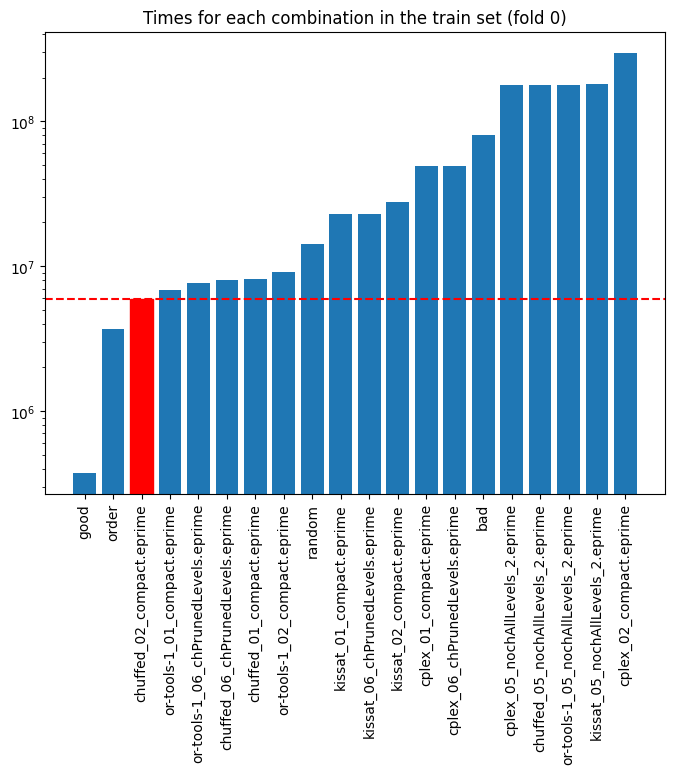

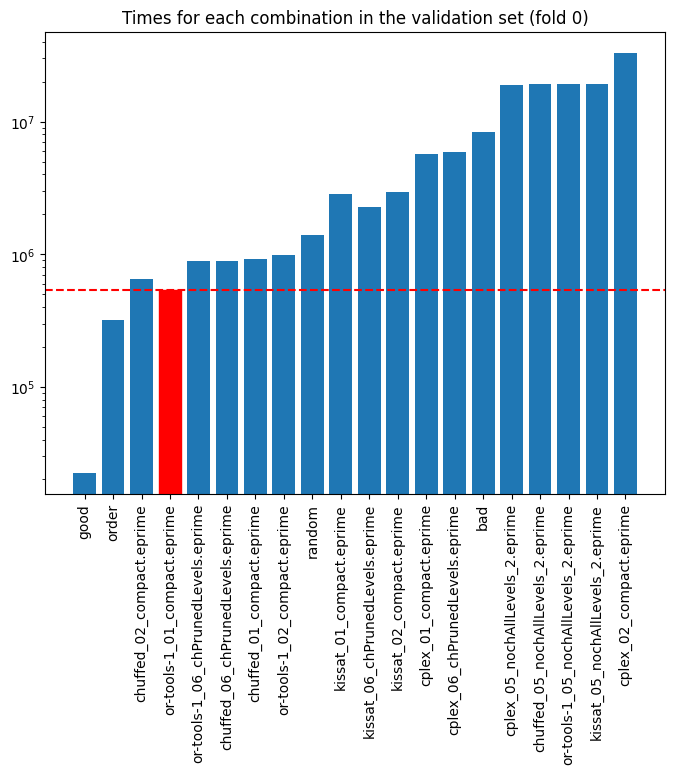

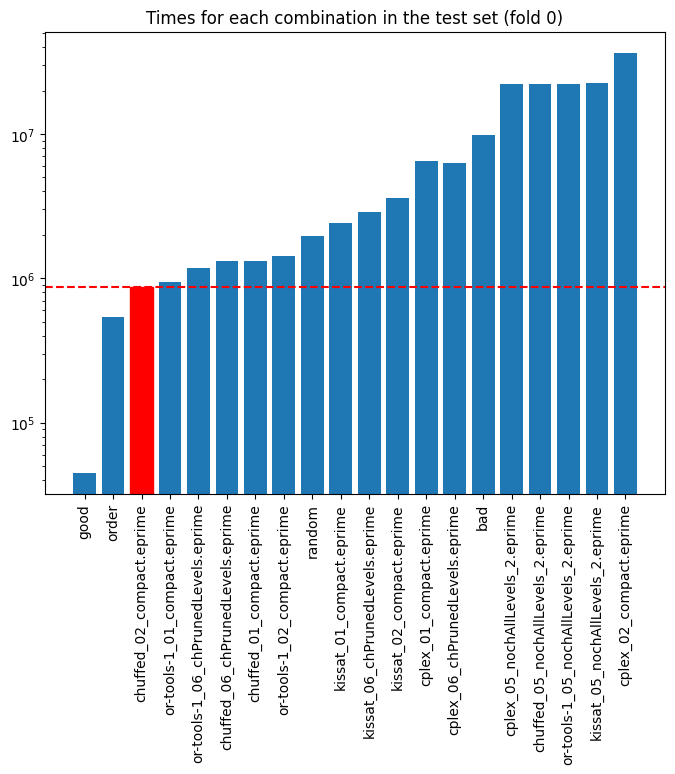

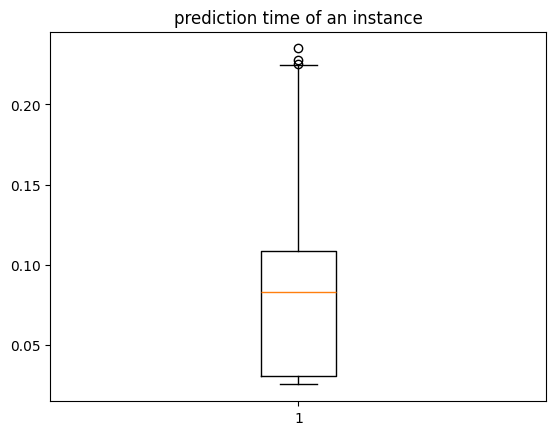

In [6]:
get_fold_results(0)

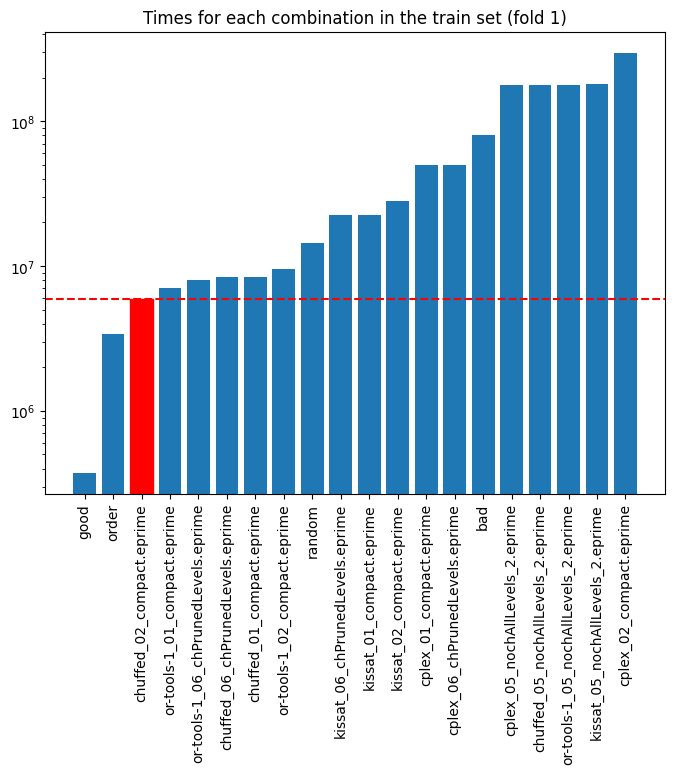

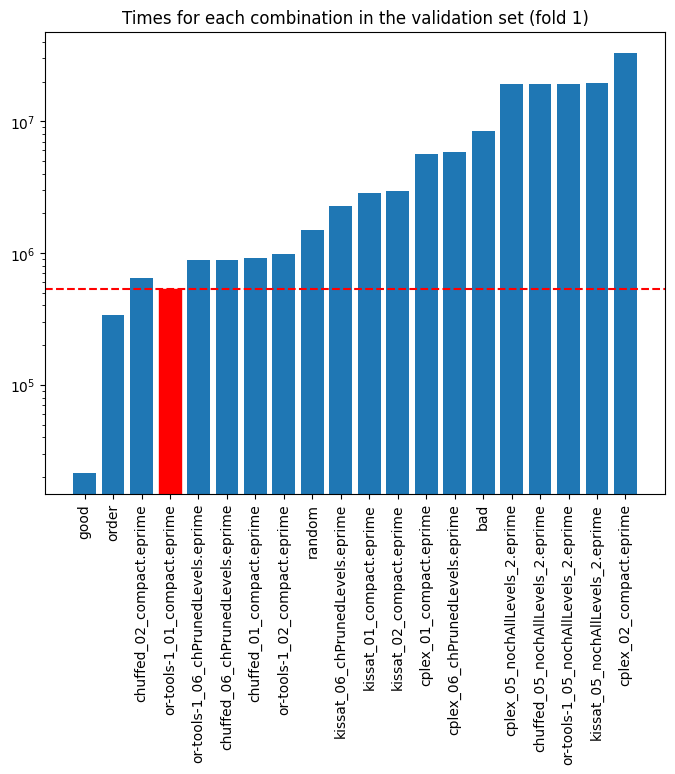

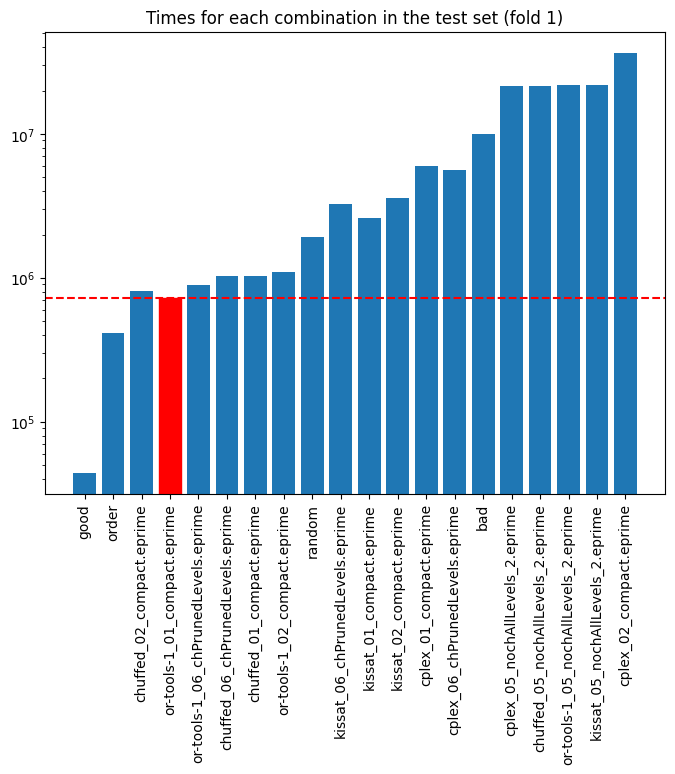

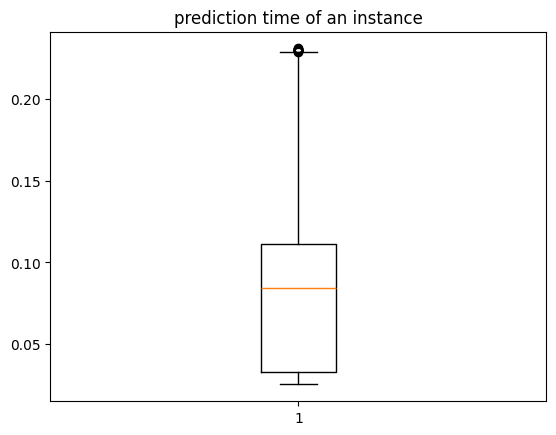

In [7]:
get_fold_results(1)

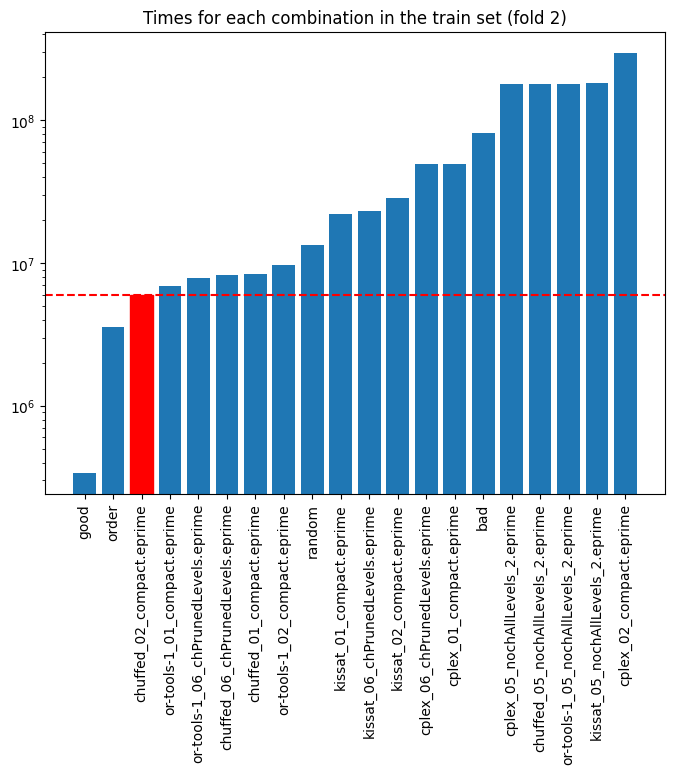

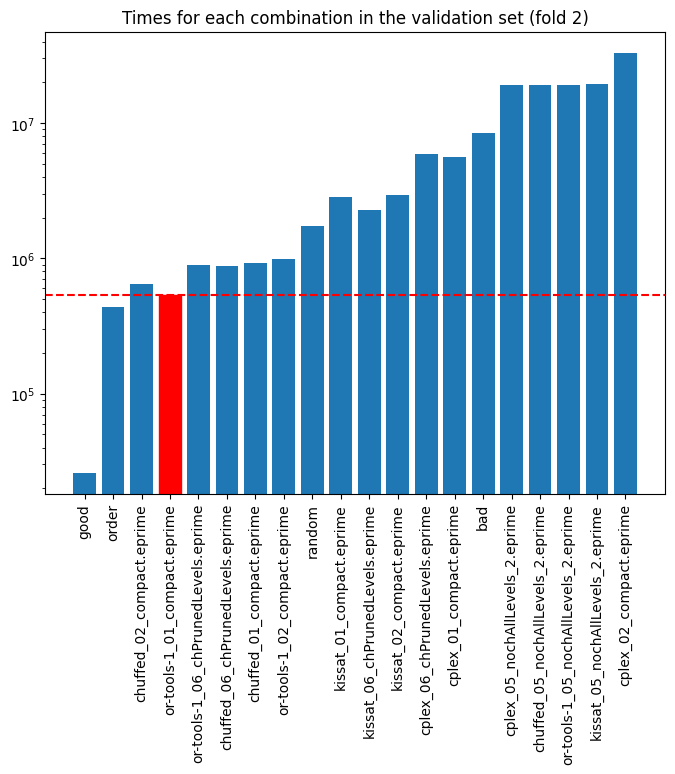

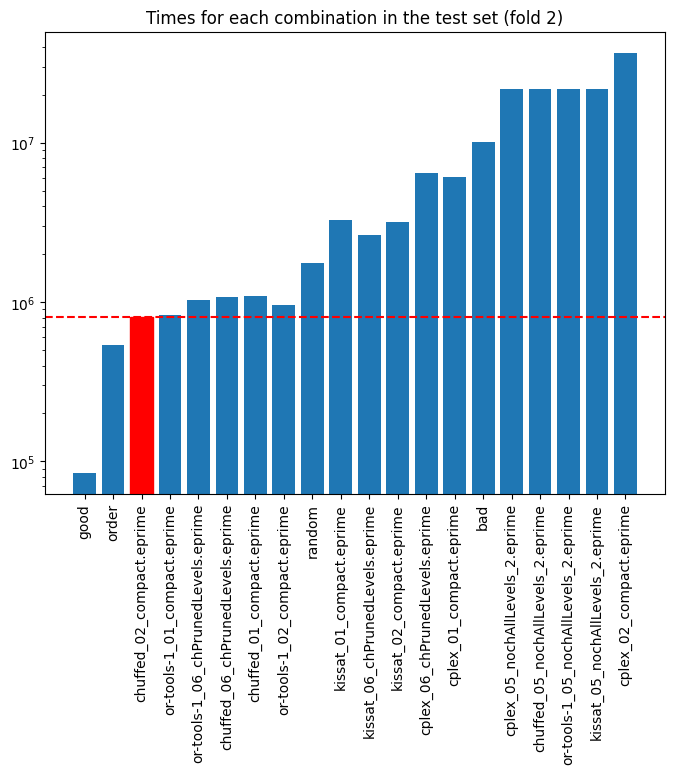

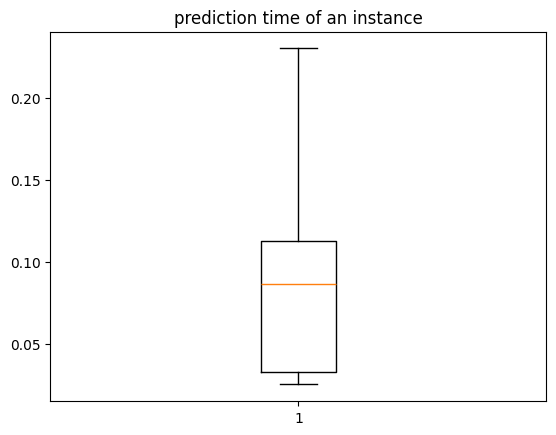

In [8]:
get_fold_results(2)

In [9]:
def load_history(fold):
    base = "../competitive_data/history/"
    files = [os.path.join(base, file) for file in os.listdir(base) if f"fold_{fold}" in file]
    train_history = {}
    for file in files:
        time = file.split("_")[-1].replace(".json", "")
        f = open(file)
        train_history[time] = json.load(f)
        f.close()
    sorted_keys = sorted(train_history.keys(), key=lambda x: int(x[1:]))

    train_history = {key: train_history[key] for key in sorted_keys}
    colors = ['blue', 'red']
    loss_history = {}
    accuracy_history = {}
    f1_history = {}
    precision_history = {}
    recall_history = {}
    for time_stamp in train_history:
        for dataset in train_history[time_stamp]:
            if not dataset in loss_history:
                loss_history[dataset] = []
                accuracy_history[dataset] = []
                f1_history[dataset] = []
                precision_history[dataset] = []
                recall_history[dataset] = []
            loss_history[dataset] += train_history[time_stamp][dataset]["loss"]
            accuracy_history[dataset] += train_history[time_stamp][dataset]["accuracy"]
            f1_history[dataset] += train_history[time_stamp][dataset]["f1_score"]
            precision_history[dataset] += train_history[time_stamp][dataset]["precision"]
            recall_history[dataset] += train_history[time_stamp][dataset]["recall"]
    for i, (key, values) in enumerate(loss_history.items()):
        plt.plot([i + 1 for i in range(len(values))], values, color=colors[i % len(colors)], label=key) 
    plt.axvline(3, color="green")
    plt.text(2.8, min(values), f'change of lr', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.axvline(6, color="green")
    plt.text(5.8, min(values), f'change of loss', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.legend()
    plt.title(f"loss history (fold {fold})")
    plt.savefig(f'../competitive_data/imgs/loss_history_{dataset}_fold_{fold}.svg', format='svg')
    plt.show()
    
    for i, (key, values) in enumerate(accuracy_history.items()):
        plt.plot([i + 1 for i in range(len(values))], values, color=colors[i % len(colors)], label=key) 
    plt.axvline(3, color="green")
    plt.text(2.8, min(values), f'change of lr', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.axvline(6, color="green")
    plt.text(5.8, min(values), f'change of loss', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.legend()
    plt.title(f"accuracy history (fold {fold})")
    plt.savefig(f'../competitive_data/imgs/accuracy_history_{dataset}_fold_{fold}.svg', format='svg')
    plt.show()

    for i, (key, values) in enumerate(f1_history.items()):
        plt.plot([i + 1 for i in range(len(values))], values, color=colors[i % len(colors)], label=key) 
    plt.axvline(3, color="green")
    plt.text(2.8, min(values), f'change of lr', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.axvline(6, color="green")
    plt.text(5.8, min(values), f'change of loss', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.legend()
    plt.title(f"f1 history (fold {fold})")
    plt.savefig(f'../competitive_data/imgs/f1_history_{dataset}_fold_{fold}.svg', format='svg')
    plt.show()

    for i, (key, values) in enumerate(precision_history.items()):
        plt.plot([i + 1 for i in range(len(values))], values, color=colors[i % len(colors)], label=key) 
    plt.axvline(3, color="green")
    plt.text(2.8, min(values), f'change of lr', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.axvline(6, color="green")
    plt.text(5.8, min(values), f'change of loss', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.legend()
    plt.title(f"precision history (fold {fold})")
    plt.savefig(f'../competitive_data/imgs/precision_history_{dataset}_fold_{fold}.svg', format='svg')
    plt.show()

    for i, (key, values) in enumerate(recall_history.items()):
        plt.plot([i + 1 for i in range(len(values))], values, color=colors[i % len(colors)], label=key) 
    plt.axvline(3, color="green")
    plt.text(2.8, min(values), f'change of lr', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.axvline(6, color="green")
    plt.text(5.8, min(values), f'change of loss', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.legend()
    plt.title(f"recall history (fold {fold})")
    plt.savefig(f'../competitive_data/imgs/recall_history_{dataset}_fold_{fold}.svg', format='svg')
    plt.show()

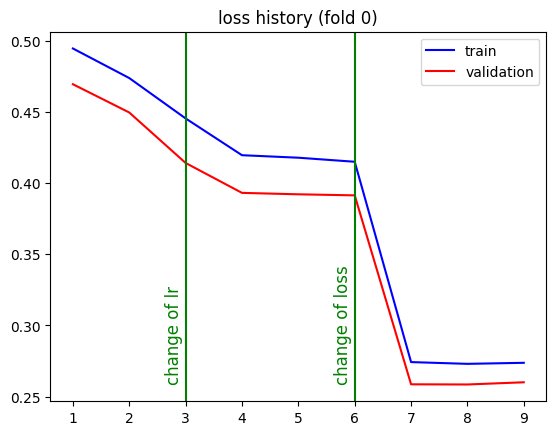

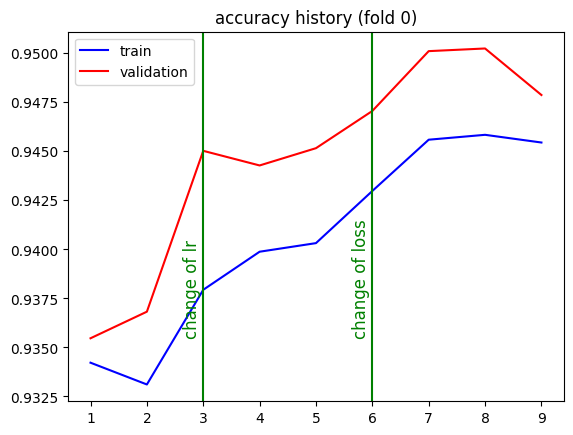

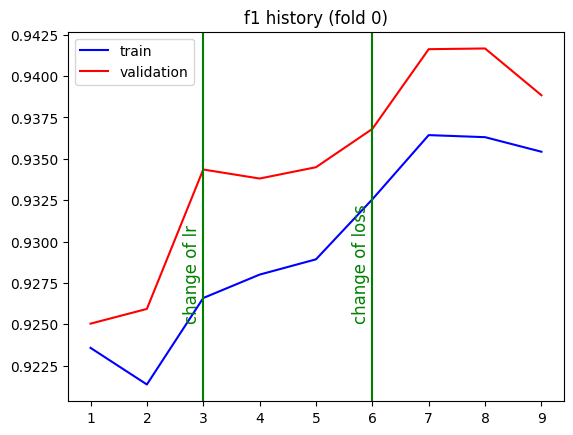

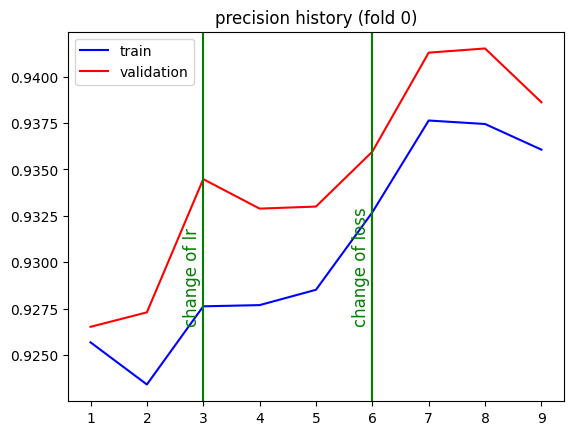

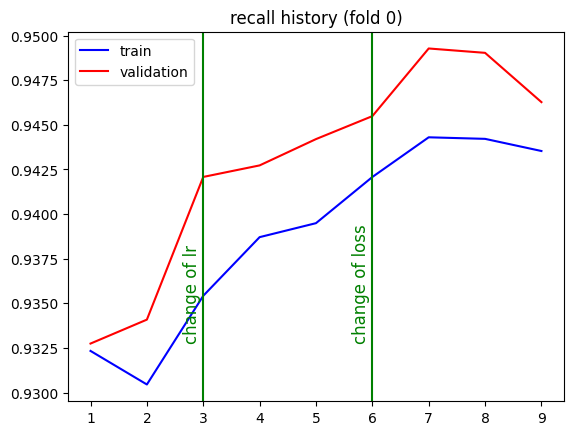

In [12]:
load_history(0)

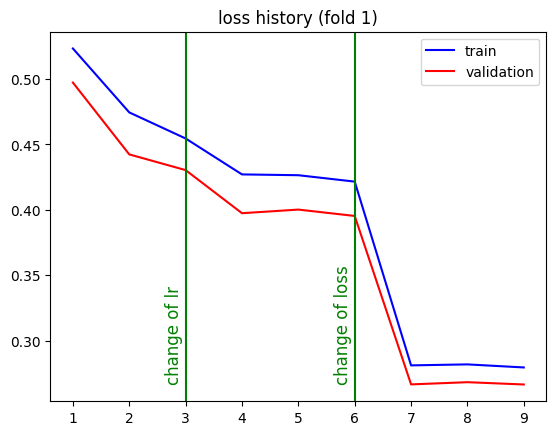

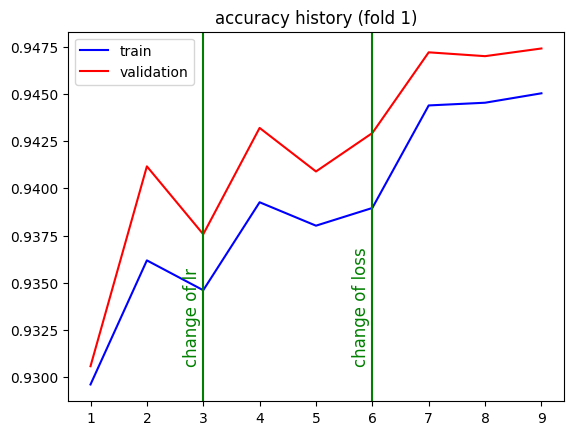

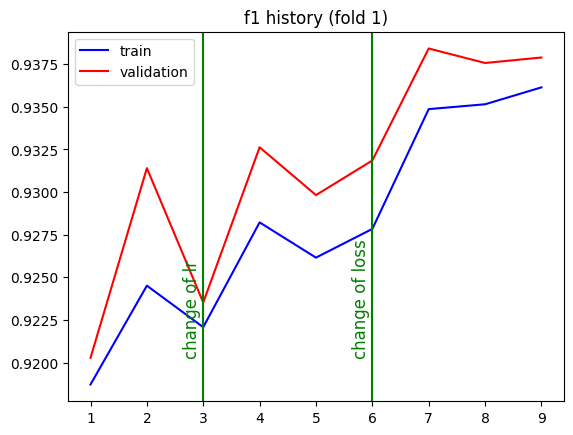

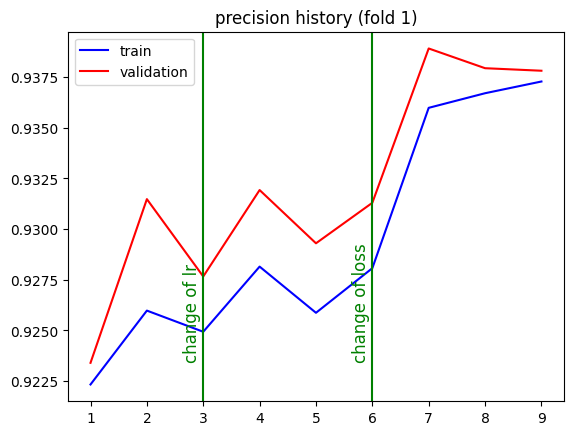

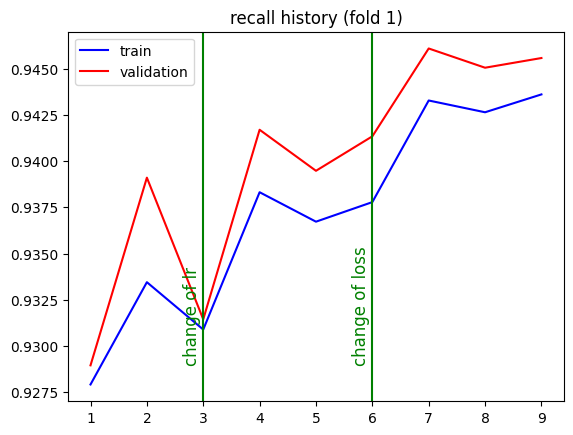

In [13]:
load_history(1)

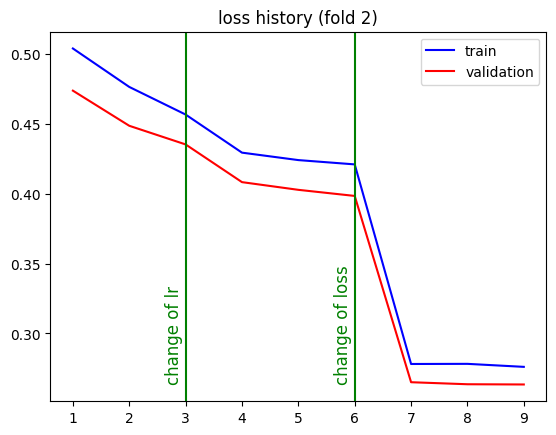

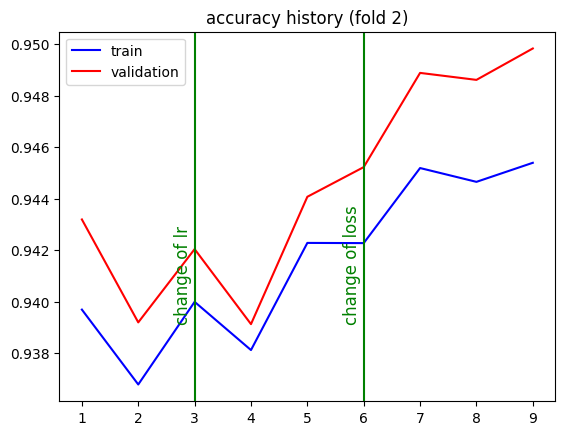

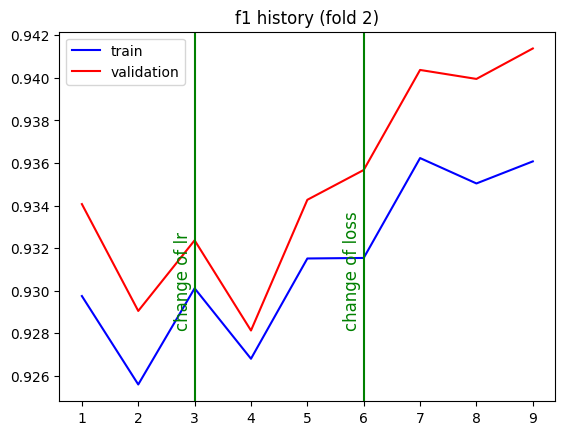

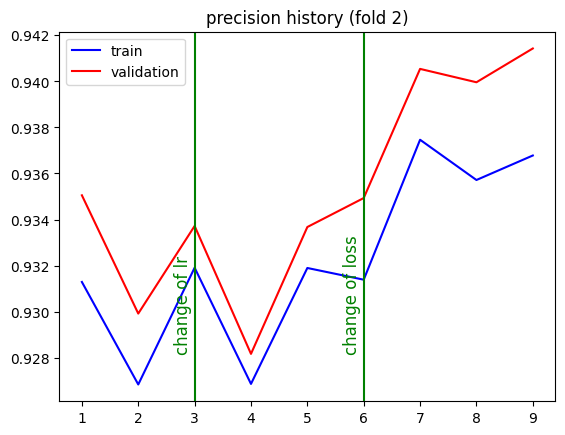

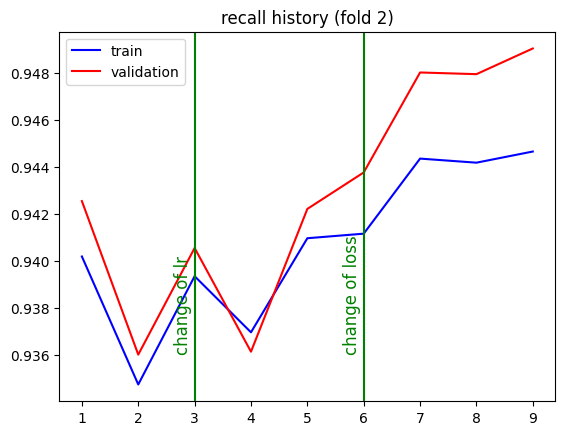

In [14]:
load_history(2)

In [15]:

def analyse_prediction(preds, trues):

    fp, fn, tp, tn = 0, 0, 0, 0
    undetected_timeouts, true_timeouts = 0, 0
    jt = 0
    for i in range(len(preds)):
        y_true = trues[i]
        y_pred = preds[i]
        if len(y_pred) == sum(y_pred):
            jt +=1
        for idx in range(len(y_pred)):
            if y_pred[idx] == y_true[idx]:
                if y_pred[idx] == 1:
                    tp +=1
                else:
                    tn +=1
            else:
                if y_pred[idx] == 1:
                    fp +=1
                else:
                    fn +=1
    return {"fp":fp, "fn":fn, "tp":tp, "tn":tn, 
            "jt":jt, "undetected_timeouts": undetected_timeouts, "true_timeouts": true_timeouts
            }


In [66]:
fold = 0
f = open(f"../competitive_data/results/final_results_{fold}.json")
fold_results = json.load(f)
f.close()
true = [p["true"] for p in fold_results["train"]["predictions"]]
pred = [p["pred"] for p in fold_results["train"]["predictions"]]
res = analyse_prediction(pred, true)
precision = res['tp'] / (res['tp'] + res['fp'])
recall = res['tp'] / (res['tp'] + res['fn'])
f1 = 2 * (precision * recall) / (precision + recall)

precision, recall, f1

(0.6492979254348393, 0.4274942066479481, 0.5155518753188374)

In [15]:
import seaborn as sns

In [10]:
f = open(f"../competitive_data/results/final_results_{0}.json")
fold_results = json.load(f)
f.close()

In [17]:
choices = {"train": fold_results["train"]["choiches"], "validation": fold_results["validation"]["choiches"], "test": fold_results["test"]["choiches"]}

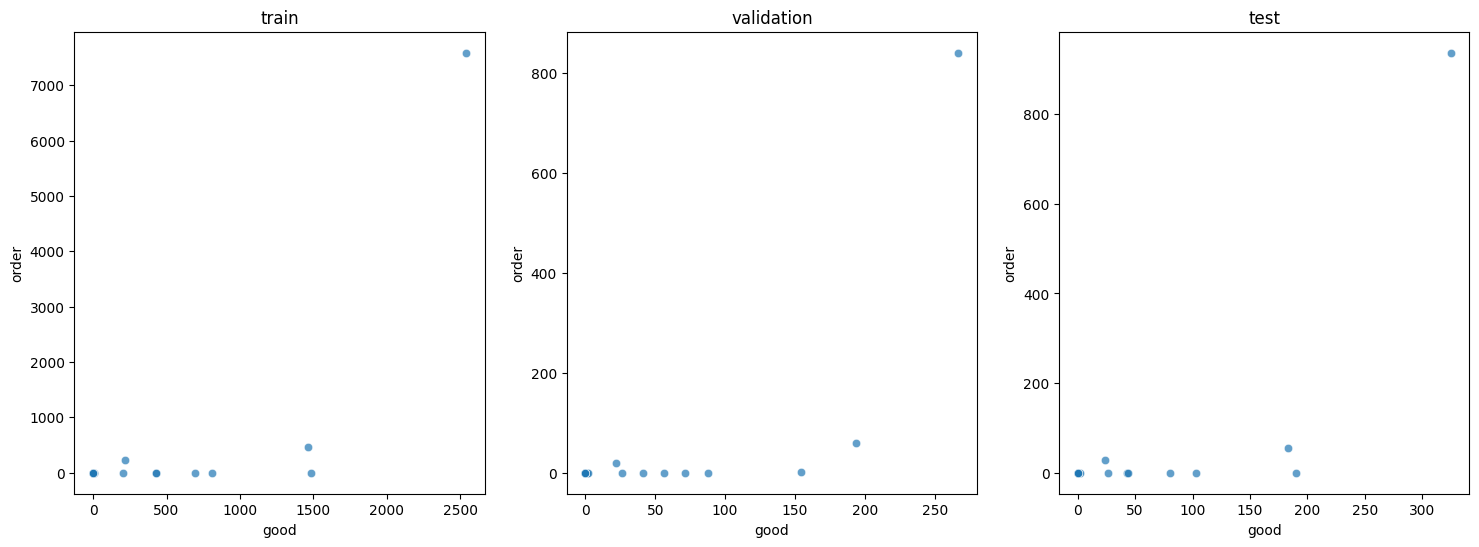

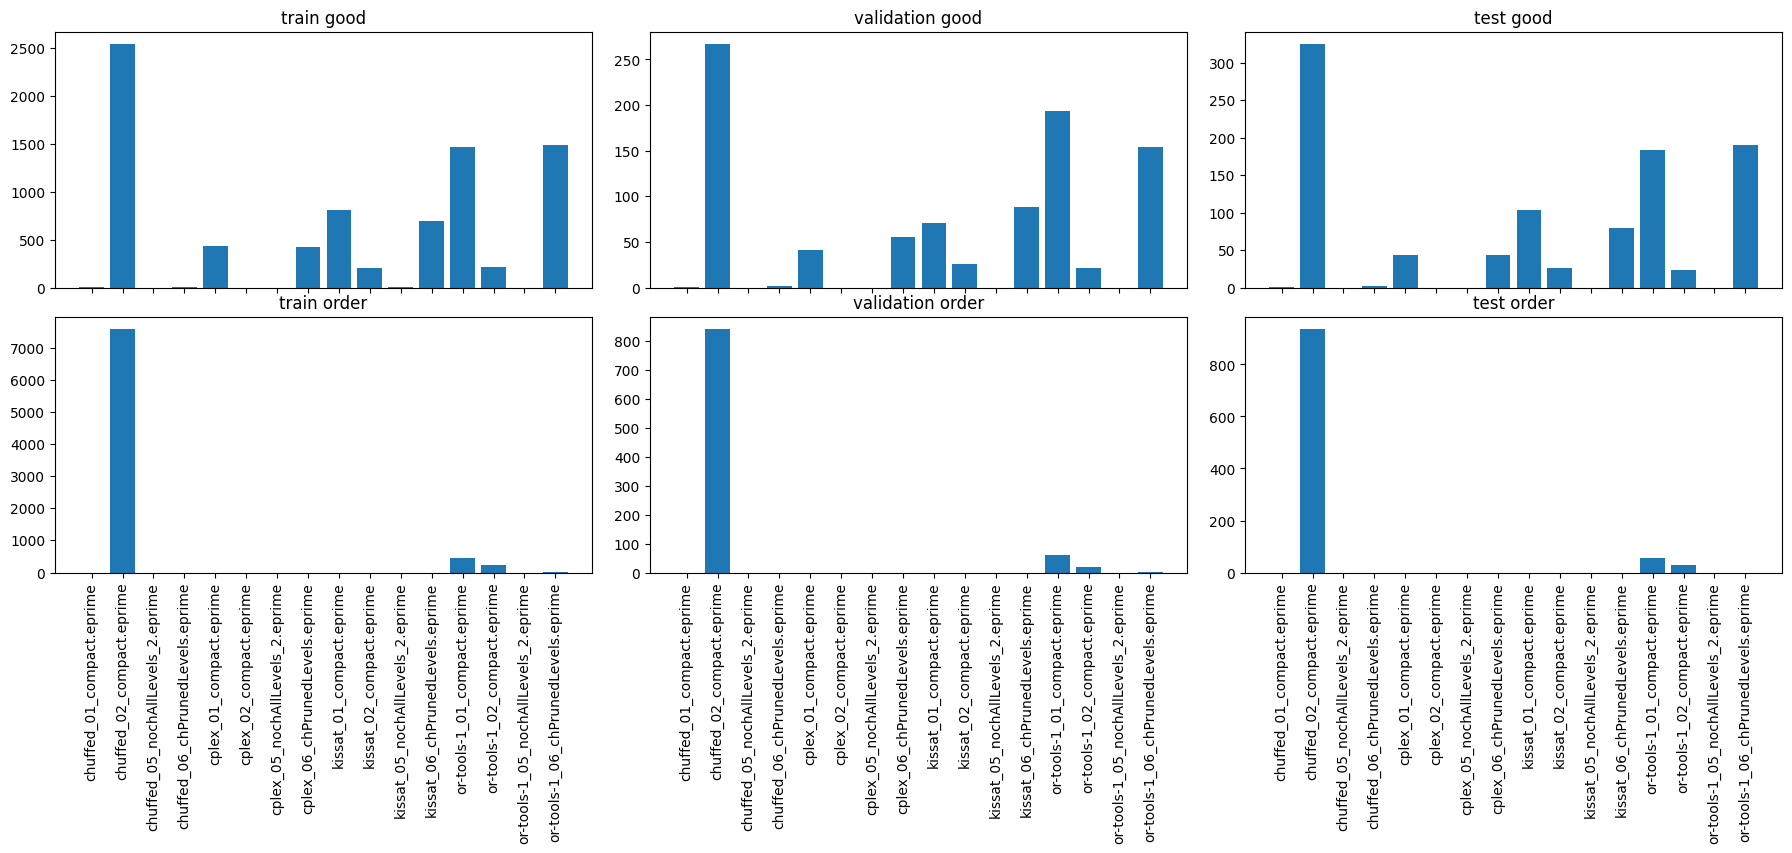

In [44]:
fig, axs = plt.subplots(1,3, figsize=(18, 6))
fig_bar, axs_bar = plt.subplots(2,3, figsize=(18, 6), sharex=True)
fig_bar.tight_layout()
for i, set in enumerate(choices.keys()):
    data_to_plot = pd.DataFrame([{"comb": comb, "good":choices[set]["good"][comb], "order":choices[set]["order"][comb] } for comb in choices[set]["good"].keys()])
    axs_bar[0][i].bar(list(choices[set]["good"].keys()), list(choices[set]["good"].values()))
    axs_bar[1][i].bar(list(choices[set]["order"].keys()), list(choices[set]["order"].values()))
    axs_bar[0][i].title.set_text(f"{set} good")
    axs_bar[1][i].title.set_text(f"{set} order")
    axs[i].title.set_text(set)
    axs_bar[0][i].set_xticks(range(16), labels=list(choices[set]["order"].keys()), rotation=90)
    axs_bar[1][i].set_xticks(range(16), labels=list(choices[set]["order"].keys()), rotation=90)
    sns.scatterplot(ax=axs[i], data=data_to_plot, x="good", y="order", markers='x', alpha=.7)